## 정상성/비정상성 : stationary/non-stationary
추세나 계절성이 있는 시계열은 정상성을 나타내는 시계열이 아닙니다 — 추세와 계절성은 서로 다른 시간에 시계열의 값에 영향을 줄 것이기 때문입니다. 

In [1]:
from statsmodels.tsa.stattools import adfuller, kpss
import pandas as pd

C:\Users\taeeu\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\taeeu\anaconda3\lib\site-packages\numpy\.libs\libopenblas.el2c6ple4zyw3eceviv3oxxgrn2nrfm2.gfortran-win_amd64.dll
C:\Users\taeeu\anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
df=pd.read_csv('a10.csv', parse_dates=['date'], index_col='date')

## - ADF Test

In [3]:
#H0(귀무가설) : stationary x
#H1(대립가설) : stationary o

result=adfuller(df.value.values)

print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

#p-value가 0.05보다 크므로 귀무가설을 기각할 수 없다
#비정상성

ADF Statistic: 3.14518568930675
p-value: 1.0


## - KPSS Test

In [4]:
#H0(귀무가설) : stationary o
#H1(대립가설) : stationary x

result=kpss(df['value'], regression='c')

print(f'KPSS Statistic: {result[0]}')
print(f'p-value: {result[1]}')

#p-value가 0.05보다 작으므로 귀무가설을 기각
#비정상성

KPSS Statistic: 1.3136750533447588
p-value: 0.01


C:\Users\taeeu\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
C:\Users\taeeu\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


## 차분 : 비정상성->정상성

In [5]:
df=pd.read_csv('a10.csv', parse_dates=['date'], index_col='date')

In [6]:
#diff함수 : 행-바로전 행 -> axis=0
diff=df.diff()

#결측치를 빼놓고 진행해야함
diff=diff.dropna()

In [7]:
#첫번째 차분이 정상시계열로 만들었는지 확인
result=adfuller(diff.value.values)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

#H0(귀무가설) : stationary x
#H1(대립가설) : stationary o
#p-value가 0.05보다 크기때문에 귀무가설을 기각하지 못함
#non-stationary

ADF Statistic: -2.495172147449788
p-value: 0.11665341686467584


In [8]:
#한번더 반복!

diff2=diff.diff()
diff2=diff2.dropna()
result=adfuller(diff2.value.values)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

#H0(귀무가설) : stationary x
#H1(대립가설) : stationary o
#귀무가설 기각!
#stationary해짐

ADF Statistic: -10.292304706517312
p-value: 3.543916358529571e-18


## 시계열 분해(추세/계절 성분 제거)

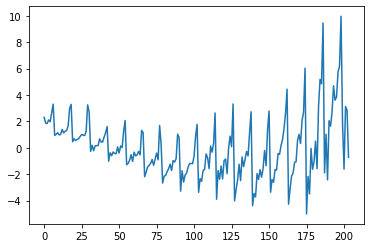

In [10]:
#시계열에서 최적 적합선 빼기
from scipy import signal
import matplotlib.pyplot as plt

df=pd.read_csv('a10.csv', parse_dates=['date'], index_col='date')

#timeseries값에 대해 추세(trend)분해
detrended=signal.detrend(df.value.values)
plt.plot(detrended)

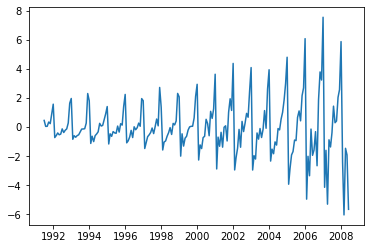

In [13]:
#시계열 분해에서 추세 성분 빼기
from statsmodels.tsa.seasonal import seasonal_decompose

#multiplicative:승법모델
## extrapolate_trend='freq' : Trend 성분을 만들기 위한 rolling window 때문에 필연적으로 trend, resid에는 Nan 값이 발생하기 때문에, 이 NaN값을 채워주는 옵션이다.
result_mul=seasonal_decompose(df['value'], model='multiplicative', extrapolate_trend='freq')
detrended=df.value.values-result_mul.trend
plt.plot(detrended)
#계절, 에러만 남음

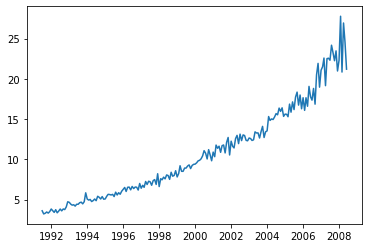

In [14]:
#시계열을 계절지수로 나눠줌
from statsmodels.tsa.seasonal import seasonal_decompose

result_mul=seasonal_decompose(df['value'], model='multiplicative')
detrended=df.value.values / result_mul.seasonal
plt.plot(detrended)
#추세, 에러만 남음

## 결측값 처리
1. forward/backward fill
2. Interpolation
3. Mean of nearest neighbors

In [15]:
# 1. forward/backward fill을 통해 결측치 보강
df=pd.read_csv('a10.csv', parse_dates=['date'], index_col='date')

#forward fill : ffill()
#backward fill : bfill()
df_ffill=df.ffill()
df_bfill=df.bfill()

In [17]:
# 2. Interpolation
from scipy.interpolate import interp1d
df=pd.read_csv('a10.csv', parse_dates=['date'], index_col='date')

In [19]:
#Linear
import numpy as np
df['rownum']=np.arange(df.shape[0])
df_nona=df.dropna(subset=['value'])

#kind='linear'/'cubic'...등등의 방법
f=interp1d(df_nona['rownum'], df_nona['value'])
df['linear_fill']=f(df['rownum'])